# Introduction

What he changed to get his good result

- More iterations
- Automatically switchin learning rate
- `2.1701` is his best loss on the Ydev split

Other things one could change

- Number of neurons
- Embedding dimensionality
- Context window
- learning rate
- batch size

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


One might split into 
training split, validation split, test split
80%, 10%, 10%

You're only allowed to use the test split occaisonally not too often

In [59]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [77]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 180), generator=g)
b1 = torch.randn(180, generator=g)
W2 = torch.randn((180, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [78]:
lri = []
lossi = []
stepi = []


In [79]:


for i in range(150000):

  # minibatch
  xi = torch.randint(0, Xtr.shape[0], (96,))

  # forward pass
  emb = C[Xtr[xi]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[xi])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 120000 else 0.01
  for p in parameters:
    p.data += - lr * p.grad

  #track stats
  stepi.append(i)
  lossi.append(loss.log10().item())


# This is the loss for the latest minibatch
print(loss.item())


2.14510440826416


1. Just 30.000 Xdev: 2.4...
2. Total 60k Xdev:   2.37
3. With 100k :       2.3063
4. With 200k :       2.2944
5. With 100k with changing lr :       2.2003,
6. With 100k and changing lr and batchsize 48: 2.1997
7. With 150k changing lr and batchsize 96:     2.1781
8. Same but with larger layer (250) : 2.1855

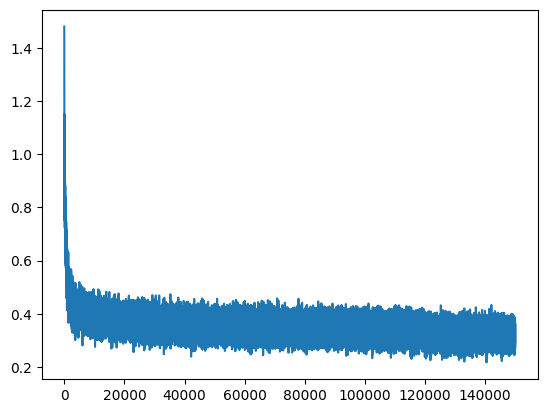

In [70]:
# plt.plot((1,2,3,4,),(7,9,0,4))
plt.plot(stepi, lossi)

Training Error

In [72]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1180, grad_fn=<NllLossBackward0>)

Validation Error

In [73]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1855, grad_fn=<NllLossBackward0>)

# Sampling from the Model

This is just extra. The better your model the more should the output look like names.

In [39]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mara.
amyanniee.
mad.
ayah.
ten.
rajekdolek.
aderron.
lilandy.
jena.
keiseananaranaya.
malara.
neshabvikahiriel.
kanie.
tel.
panteron.
ubasted.
rayshan.
els.
kar.
avek.
